In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
import pickle as pkl
import sys

from sklearn.metrics import roc_curve
# Own modules
module_path = os.path.dirname(os.getcwd())
sys.path.append(os.path.abspath(module_path))

results_dir = os.path.join(module_path, 'datasets', 'results')

In [2]:
# Some config (do not change)

plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12

C:\Users\anton.krause\AppData\Local\Temp\ipykernel_14780\2150607869.py:95: UserWarning: The label '_child8' of <matplotlib.lines.Line2D object at 0x0000017CECBBFE80> starts with '_'. It is thus excluded from the legend.
  color_legend = plt.gca().legend(handles=line_handles, ncols=2, fontsize=12, title='Standard deviation of $\epsilon_j$')
C:\Users\anton.krause\AppData\Local\Temp\ipykernel_14780\2150607869.py:95: UserWarning: The label '_child9' of <matplotlib.lines.Line2D object at 0x0000017CEE1B8160> starts with '_'. It is thus excluded from the legend.
  color_legend = plt.gca().legend(handles=line_handles, ncols=2, fontsize=12, title='Standard deviation of $\epsilon_j$')
C:\Users\anton.krause\AppData\Local\Temp\ipykernel_14780\2150607869.py:95: UserWarning: The label '_child10' of <matplotlib.lines.Line2D object at 0x0000017CEE1B8400> starts with '_'. It is thus excluded from the legend.
  color_legend = plt.gca().legend(handles=line_handles, ncols=2, fontsize=12, title='Standard d

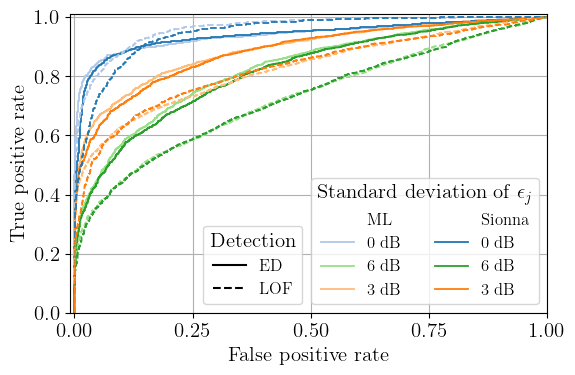

In [3]:
su_height = 1.5 # height of the SUs in meters, results available for 1.5 and 5.0 meters
methods = ['energy_detector', 'lof']   # energy_detector, lof

noise_values_to_plot = [0, 3, 6]

font_size = 15

markers_by_dt_type = {'Sionna': 'o', 'ML': 'v'}
linestyle_by_algorithm = {'energy_detector': '-', 'lof': '--'}

dataset_idx_by_dt_type = {'Sionna-1.5': 0, 'ML-1.5': 1, 'Sionna-5.0': 2, 'ML-5.0': 3}

su_height_str = f'{su_height:.1f}'

if su_height == 1.5:
    plot_colorbar = True
else:
    plot_colorbar = True

# Get the original tab20 segmented colormap with 20 colors
tab20 = plt.cm.get_cmap('tab20')

# Create two colormaps, a dark one for Sionna and a light one for ML
colors_si = []
colors_ml = []
for i in range(0, 6, 2):
    colors_si.append(tab20(i))
    colors_ml.append(tab20(i+1))
cmap_si = mcolors.ListedColormap(colors_si)
cmap_ml = mcolors.ListedColormap(colors_ml)


plt.rcParams['figure.figsize'] = (6, 4)
old_font_size = plt.rcParams['font.size']
plt.rcParams['font.size'] = font_size

fig = plt.figure()


# Load results from file
results = {}
for dt_type in ['ML', 'Sionna']:
    idx_key = f'{dt_type}-{su_height_str}'
    with open(os.path.join(results_dir, f'sionna_{dataset_idx_by_dt_type[idx_key]}_prob.pkl'), 'rb') as f_results:
        results[dt_type] = pkl.load(f_results)

line_handles = []

def plot_method(method):

    # Calculate and plot the ROC curve for each method
    for dt_type in ['ML', 'Sionna']:

        if method == 'energy_detector':
            line_handles.append(plt.plot([], [], color='white', label=dt_type)[0])

        for noise_std in results[dt_type][method]:

            if noise_std not in noise_values_to_plot:
                continue


            fpr, tpr, thresholds = roc_curve(results[dt_type][method][noise_std]['y_test'],
                                            results[dt_type][method][noise_std]['y_hat'])

            if dt_type == 'Sionna':
                c = cmap_si(noise_std/6)
            elif dt_type == 'ML':
                c = cmap_ml(noise_std/6)

            
            if method == 'energy_detector':
                label = f'{noise_std} dB'
            else:
                label = None


            line_handles.append(
                plt.plot(
                    fpr,
                    tpr,
                    color=c,
                    linestyle=linestyle_by_algorithm[method],
                    markerfacecolor='none',
                    linewidth=1.3, markersize=7,
                    label=label
                )[0]
            )



for method in methods:
    plot_method(method)

color_legend = plt.gca().legend(handles=line_handles, ncols=2, fontsize=12, title='Standard deviation of $\epsilon_j$')

# Add legend entries for the type of algorithm
ed_line, = plt.plot([], [], color='black', linestyle=linestyle_by_algorithm['energy_detector'], label='ED')
lof_line, = plt.plot([], [], color='black', linestyle=linestyle_by_algorithm['lof'], label='LOF')

# Plot the 50-50 line
# plt.plot([0, 1], [0, 1], color='black', linestyle=':', label='No skill')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xlim([-0.01, 1])
plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0])
plt.ylim([0, 1.01])
plt.grid()


plt.legend(handles=[ed_line, lof_line], loc=[0.28, 0.03], fontsize=12, title='Detection')
plt.gca().add_artist(color_legend)
plt.tight_layout()


fig_path = os.path.join(module_path, 'figures', f'roc_joint_rx{su_height_str}m.png')
plt.savefig(fig_path, dpi=300, bbox_inches='tight')

plt.rcParams['font.size'] = old_font_size